# Test code to read in & stitch GelSight scans of an object

This interactive notebook documents the gspython code for stitching together GelSight scans of a single object in more detail, and allows the user to test different functions.

### Requirements

built-in module `os`

built-in module `sys`

built-in module `random`

open source module `numpy`

open source module `scipy`

open source module `opencv`

open source module `matplotlib`

open source package `gspython` with modules `readscan` and `readtmd`

### Functions

`readdata` Crawls parent directory to find scans of object and reads in heightmap and photographic data, optionally normalizing for background variation.

`subtractgrad` Subroutine which normalizes image for background variation by subtracting out bilinear gradient from image corners.

`denserect` Subroutine which, given 2D histogram data, returns rectangle bounding four largest bins. 

`stitchborderpyr` Subroutine which uses Gaussian pyramids to vertically blend two images. Based on OpenCV demo code at https://docs.opencv.org/3.4/dc/dff/tutorial_py_pyramids.html.

`getmatches` Subroutine which detects and computes matches between features in the two input images. 

`stitchscans` Reads and stitches together scans of objects in fdata.

## Flowchart description of stitch.py routine

<h4 style="text-align: center">
    
    stitch.py script
    
</h4>

$$ \downarrow $$

<h4 style="text-align: center">
    
    stitchscan.stitchscans() call
    
</h4>

$$ \downarrow $$

<h5 style="text-align: center">
    
    Loop through each object
    
    stitchscan.readdata() call to get scan data for object
    
    Iterate through pairs of consecutive scans
    
</h5>

$$ \downarrow $$

<div style="text-align: center">
    
    stitchscan.getmatches() call to match features in pair of photographs
    
    Compute 2D histogram of matches within scan
    
    stitchscan.denserect() call to select area with good signal-to-noise ratio
    
    Compute least-squares affine transformation from matches in selected area
    
    Blend overlapping region to obtain stitched image
    
</div>

$$ \downarrow $$

<h5 style="text-align: center">
    
    Output final stitched photograph and heightmap of entire object
    
</h5>

## Performance compared to built-in cv.Stitcher class

During testing, we found that the `SIFT` method for detecting and computing matches was generally more robust than either the built-in `cv.Stitcher` tool or the open-source `cv.ORB` algorithm. You can test these methods below.

## Running the code

First, we import the dependencies:

In [4]:
import os
import sys
import numpy as np
import scipy
import random
import cv2 as cv
from matplotlib import pyplot as plt

sys.path.append(r"../")
import readscan
import readtmd

### Testing functions

Next, we define the necessary functions. The below code blocks can be edited and executed independently to test the different methods.

In [31]:
def readdata(parent,allowance=10,baseline=75,normalize_height=True,reverse_order=False):
    scans = []
    hdata = {}
    hmaps = []
    ims = []
    
    # crawl directory and find individual scans
    for root, dirs, files in os.walk(parent):
        for name in dirs:
            if 'Scan' in name:
                scans.append(name)
    scans.sort(reverse=reverse_order)

    # for each scan read in heightmap and corresponding composite photograph
    for i in range(len(scans)):
        s = scans[i]
        spath = parent + s + '/' + 'scan.yaml'
        if not os.path.exists(spath):
            print('Cannot find raw scan file for specified path')
            break
    
        hpath = parent + s + '/' + s + '.tmd'
        if not os.path.exists(hpath):
            print('Cannot find TMD file for specified path')
            break

        hdata[i] = readtmd.readtmd(hpath)
        im = cv.imread(parent + s + '/' + 'thumbnail.jpg')
        
        # normalize corners of image by subtracting out mask      
        ims.append(subtractgrad(im,baseline=baseline,allowance=allowance))

        # normalize gradient for heightmap if option is turned on        
        hm = hdata[i][0]
        if normalize_height:
            hm = subtractgrad(hm,baseline=0,allowance=allowance)
        hmaps.append(hm)
        
    return scans,hmaps,ims

In [33]:
def subtractgrad(im, baseline=0, allowance=10):
    height,width = im.shape[:2]
    a = 1
    if len(im.shape) > 2:
        a = im.shape[-1]
    
    # compute average value of corners
    corners = [np.average(im[:allowance, :allowance], axis = (0,1)),np.average(im[:allowance, -allowance:], axis = (0,1)),np.average(im[-allowance:, -allowance:], axis = (0,1)),np.average(im[-allowance:, :allowance], axis = (0,1))]
    
    # adjust for baseline value
    if a == 1:
        gradient = np.asarray([[corners[0]*255,corners[1]*255],[corners[3]*255,corners[2]*255]])-[[baseline,baseline],[baseline,baseline]]
    else:
        gradient = np.floor([[corners[0],corners[1]],[corners[3],corners[2]]])-[[[baseline]*a,[baseline]*a],[[baseline]*a,[baseline]*a]]
    
    # compute mask
    mask = cv.resize(gradient,None,fx=width/2,fy=height/2,interpolation=cv.INTER_LINEAR)
    if a == 1:
        return im - mask/255
    else:
        im = im-mask
        im = im.clip(0,255).astype(int)
        im = cv.normalize(im, None, 0, 255, cv.NORM_MINMAX).astype('uint8')
        return im

In [22]:
def denserect(nbins, bins):
    rect = {1:(0,(0,0)),2:(0,(0,0)),3:(0,(0,0)),4:(0,(0,0))}
    for r in range(nbins):
        for c in range(nbins):
            if bins[r][c] >= rect[1][0]:
                rect[4] = rect[3]
                rect[3] = rect[2]
                rect[2] = rect[1]
                rect[1] = (bins[r][c], (r,c))
            elif bins[r][c] >= rect[2][0]:
                rect[4] = rect[3]
                rect[3] = rect[2]
                rect[2] = (bins[r][c], (r,c))
            elif bins[r][c] >= rect[3][0]:
                rect[4] = rect[3]
                rect[3] = (bins[r][c], (r,c))
            elif bins[r][c] >= rect[4][0]:
                rect[4] = (bins[r][c], (r,c))
    lims = [rect[1][1][0],rect[1][1][0],rect[1][1][1],rect[1][1][1]]
    for i in [2,3,4]:
        if rect[i][1][0] < lims[0]:
            lims[0] = rect[i][1][0]
        elif rect[i][1][0] > lims[1]:
            lims[1] = rect[i][1][0]
        if rect[i][1][1] < lims[2]:
            lims[2] = rect[i][1][1]
        elif rect[i][1][1] > lims[3]:
            lims[3] = rect[i][1][1]
    return lims

In [5]:
def stitchborderpyr(im1, im2, levels=5, reverse=False):
    # generate Gaussian pyramids
    G = im1.copy()
    gp1 = [G]
    for i in range(levels):
        G = cv.pyrDown(G)
        gp1.append(G)
        
    G = im2.copy()
    gp2 = [G]
    for i in range(levels):
        G = cv.pyrDown(G)
        gp2.append(G)
        
    # generate Laplacian pyramids
    lp1 = [gp1[levels-1]]
    for i in range(levels-1,0,-1):
        b = gp1[i-1].shape
        GE = cv.pyrUp(gp1[i],dstsize=(b[1],b[0]))
        L = cv.subtract(gp1[i-1],GE)
        lp1.append(L)

    lp2 = [gp2[levels-1]]
    for i in range(levels-1,0,-1):
        b = gp2[i-1].shape
        GE = cv.pyrUp(gp2[i],dstsize=(b[1],b[0]))
        L = cv.subtract(gp2[i-1],GE)
        lp2.append(L)
        
    # Add top and bottom halves of images in each level
    LS = []
    for l1,l2 in zip(lp1,lp2):
        rows,cols,dpt = l1.shape
        ls = []
        if reverse:
            ls = np.vstack((l1[0:rows//2], l2[rows//2:]))
        else:
            ls = np.vstack((l2[0:rows//2], l1[rows//2:]))
        LS.append(ls)
    result = LS[0]
    for i in range(1,levels):
        b = LS[i].shape
        result = cv.pyrUp(result,dstsize=(b[1],b[0]))
        result = cv.add(result, LS[i])
        
    return result

In [48]:
def getmatches(im1, im2, ratio=0.7, mode='sift'):
    height,width,_ = im2.shape
    
    # find and match features
    if mode == 'sift':
        sift = cv.SIFT_create()
        kp1, des1 = sift.detectAndCompute(im1,None)
        kp2, des2 = sift.detectAndCompute(im2,None)
    elif mode == 'orb':
        orb = cv.ORB_create(nfeatures=32000)
        kp1, des1 = orb.detectAndCompute(im1,None)
        kp2, des2 = orb.detectAndCompute(im2,None)
        des1 = np.float32(des)
        des2 = np.float32(desn)
    else:
        print('Mode is not correctly specified, try "sift" for best results')
        return

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50) # or pass empty dictionary
    flann = cv.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)

    # ratio test as per Lowe's paper to filter for good matches
    dxy = {}
    sign = 0
    matchesMask = [[0,0] for i in range(len(matches))]
    for i,(m,n) in enumerate(matches):
        if m.distance < ratio*n.distance:
            p = kp1[m.queryIdx].pt
            pn = kp2[m.trainIdx].pt
            dy = int(pn[1] - p[1])
            dx = int(pn[0] - p[0])
            if dx != 0 and np.abs(dy) >= height/6 and p[1] < height:
                dxy[p] = [(dx,dy),pn]
                sign += dy/np.abs(dy)
                matchesMask[i]=[1,0]
                
    return kp1,kp2,matches,matchesMask,dxy,sign

In [49]:
def stitchscans(objects, allowance=20, normalize_height=True, ratio=0.7, nbins=10, levels=0, reverse_order=False, diagnose=False, mode='sift', out_dir='', tag=''):
    for parent in objects:
        if parent[-1] != '/':
            parent += '/'
        f = parent.split('/')[-2]
        print('Processing: \t',f)
        success = True
        
        # read in scan data files
        scans, hmaps, ims = readdata(parent,allowance=allowance,normalize_height=normalize_height,reverse_order=reverse_order)
        
        height,width,_ = ims[0].shape
        im = ims[0]
        hm = hmaps[0]

        # iterate through pairs of consecutive images to stitch together
        for i in range(len(scans)-1):
            hmn = hmaps[i+1]
            imn = ims[i+1]
            
            # compute best feature matches
            kp, kpn, matches, matchesMask, dxy, sign = getmatches(im,imn,ratio=ratio,mode=mode)
                        
            if diagnose:
                draw_params = dict(matchColor=(0,255,0),singlePointColor=(255,0,0),matchesMask=matchesMask,flags=cv.DrawMatchesFlags_DEFAULT)
                imx = cv.drawMatchesKnn(im,kp,imn,kpn,matches,None,**draw_params)
            
            bins, xedges, yedges = np.histogram2d([a[0] for a in dxy],[a[1] for a in dxy],bins=[[(width-1)/nbins * i for i in range(nbins+1)],[(height-1)/nbins * i for i in range((i+1)*nbins+1)]])
            bins = bins.T

            # find rectangle containing four highest density bins
            lims = denserect(nbins,bins)
            
            # diagnose matches
            if diagnose:
                cv.rectangle(imx,(int(lims[2]*width/nbins),int(lims[0]*height/nbins)),(int((lims[3]+1)*width/nbins),int((lims[1]+1)*height/nbins)),(0,0,255),5) # draw rectangle on image
                plt.clf()
                plt.imshow(imx)
                plt.show()

            # compute statistics only within rectangle to help minimize noise
            region = []
            for p in dxy:
                if p[0] >= int(lims[2]*width/nbins) and p[0] <= int((lims[3]+1)*width/nbins) and p[1] >= int(lims[0]*height/nbins) and p[1] <= int((lims[1]+1)*height/nbins):
                    if dxy[p][0][1]/np.abs(dxy[p][0][1]) == sign/np.abs(sign) and len(p) == 2 and len(dxy[p][1]) == 2:
                        region.append((p,dxy[p][1],dxy[p][0]))

            src_pts = np.float32([a[0] for a in region]).reshape(-1, 1, 2)
            dst_pts = np.float32([a[1] for a in region]).reshape(-1, 1, 2)

            # determine least squares affine transformation to stitch together scans
            transformation_rigid_matrix, rigid_mask = cv.estimateAffinePartial2D(src_pts, dst_pts)
            border = cv.perspectiveTransform(np.array([[[0, im.shape[0]]], [[im.shape[1], im.shape[0]]]], dtype=np.float32), np.array([transformation_rigid_matrix[0], transformation_rigid_matrix[1], [0,0,1]], dtype=np.float32))
            ylim = np.max([p[0][1] for p in border])
            fixed = cv.warpAffine(im, transformation_rigid_matrix, (im.shape[1],int(ylim)))
            
            # blend overlapping region 
            fborder = cv.perspectiveTransform(np.array([[[0, 0]], [[im.shape[1], 0]]], dtype=np.float32), np.array([transformation_rigid_matrix[0], transformation_rigid_matrix[1], [0,0,1]], dtype=np.float32))
            flim = int(np.max([p[0][1] for p in fborder]))
            frange = height - flim - 1
            if frange <= 0 or flim < 0:
                print('Error matching scans')
                success = False
                break
            if levels:
                fixed[flim:height,:imn.shape[1]] = stitchborder(fixed[flim:height,:imn.shape[1]],imn[flim:height],levels=levels)
            else:
                for i in range(frange):
                    fixed[flim+i+1,:imn.shape[1]] = i/frange * fixed[flim+i+1,:imn.shape[1]] + (1-i/frange) * imn[flim+i+1]
            fixed[:flim,:imn.shape[1]] = imn[:flim]
            im = fixed

            fixedhm = cv.warpAffine(hm, transformation_rigid_matrix, (im.shape[1],int(ylim)))
            fixedhm[0:height,0:width] = hmn
            hm = fixedhm
            
            # show diagnostics
            if diagnose:
                plt.clf()
                plt.imshow(im)
                plt.show()
        
        # write output images
        if not diagnose:
            if len(tag) > 0:
                tag = '_' + tag
                
            plt.clf()
            plt.imshow(im)
#             plt.show()
            out = out_dir + '/' if (len(out_dir) > 0 and out_dir[-1] != '/') else out_dir
            cv.imwrite(out + 'output/'+parent.split('/')[-2]+'_stitched'+tag+'.jpg',im)

            plt.clf()
            plt.imshow(hm,cmap='viridis')
            ax = plt.gca()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            plt.savefig(out + 'output/'+parent.split('/')[-2]+'_stitched'+tag+'_hm.jpg', dpi=300, bbox_inches='tight', pad_inches=0)
        
        # show diagnostics
        else:
            plt.clf()
            plt.imshow(hm,cmap='viridis')
            plt.show()
        
        # confirm that no warnings were triggered during algorithm run
        if success:
            print('Success')

### Stitching together multiple objects

We can stitch several objects whose folders are located in the same parent directory:

Processing: 	 Leaf2side1_n


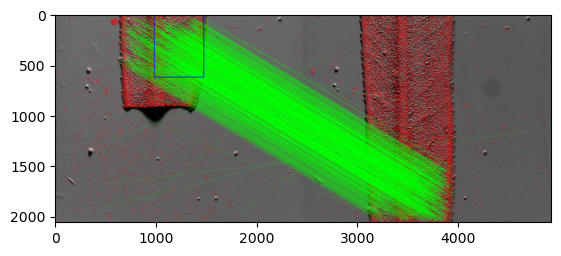

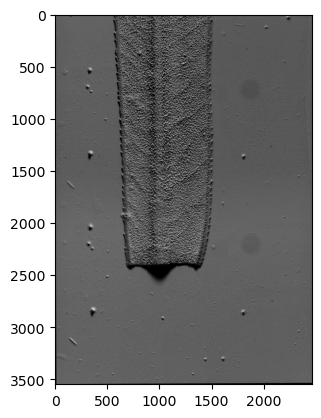

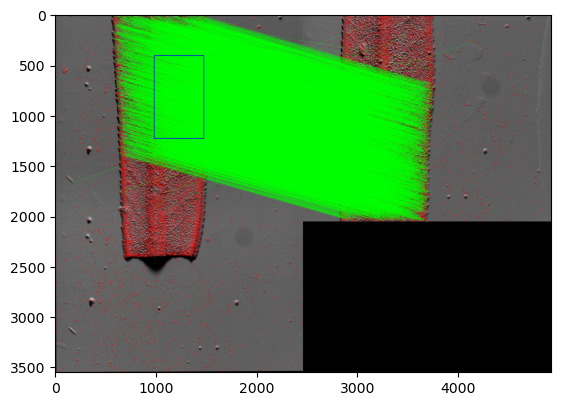

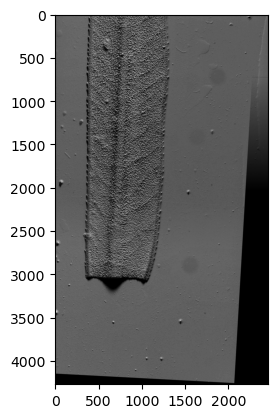

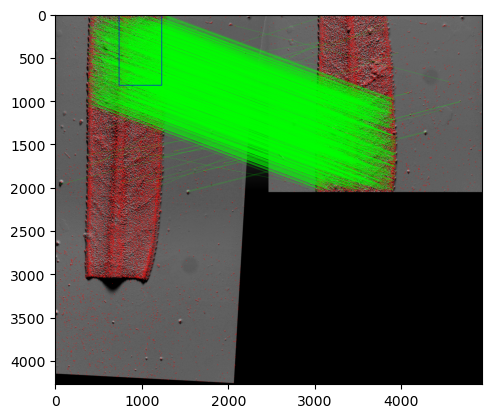

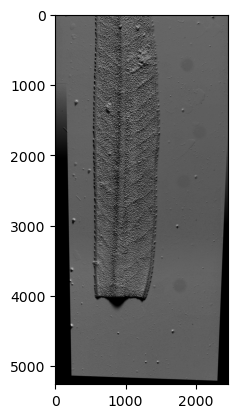

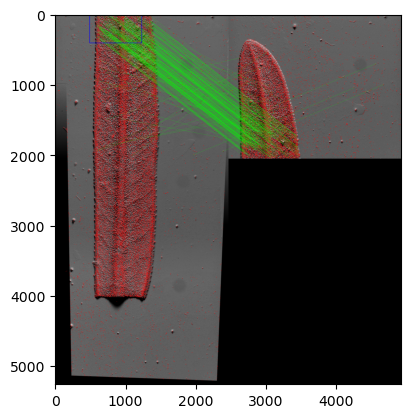

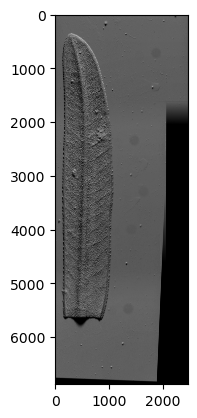

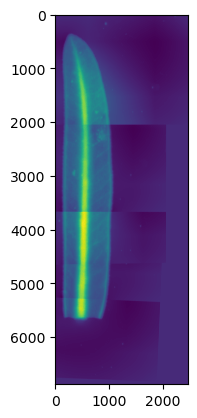

Success


In [50]:
# input parent directories containing scans of each object to stitch together
stitchscans(['./testdata/seagrass120223_processed/Leaf2side1_n/'],diagnose=True,normalize_height=True)

### Running diagnostics

It is also possible to run the stitching function in diagnostic mode, which does not save the output but provides additional information in the form of intermediate steps and matches between consecutive images.

Leaf2side2_n


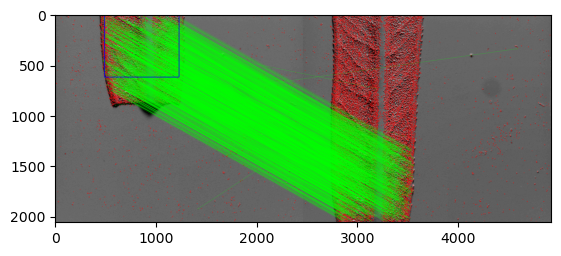

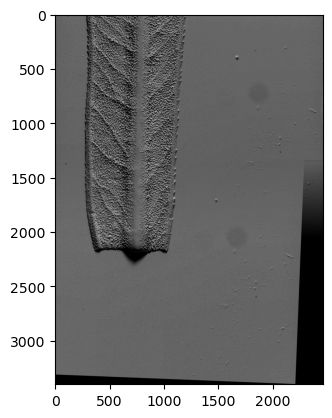

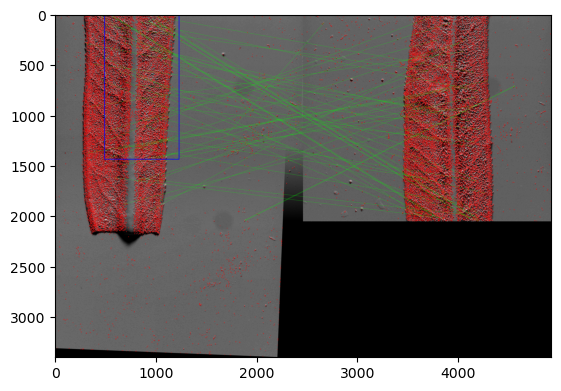

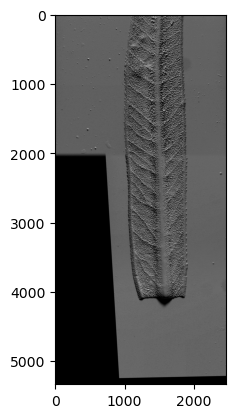

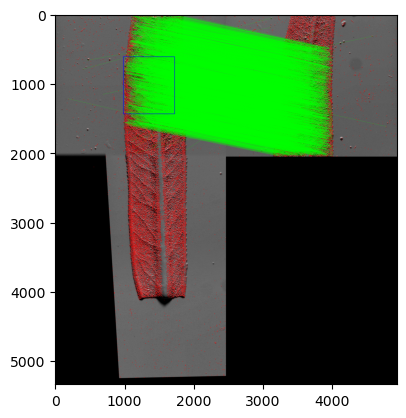

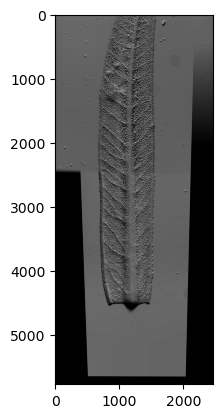

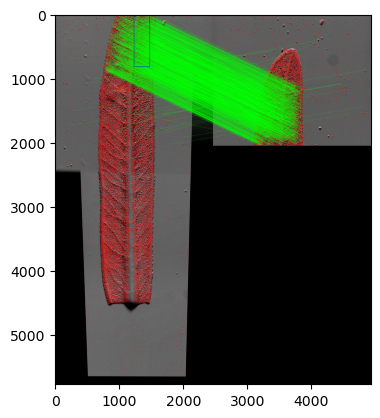

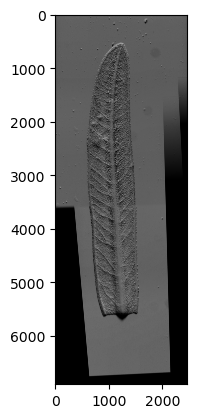

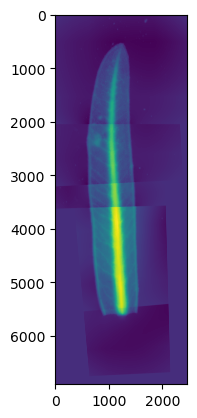

Success


In [81]:
# diagnosing scans that didn't come out well and testing methods
stitchscans(['./testdata/seagrass120223_processed/Leaf2side2_n/'],ratio=0.7,levels=0,diagnose=True,mode='sift')

## Additional functionality

There is additional documentation for the `stitchscan` code which can be viewed with the `help()` function:

In [1]:
import stitchscan
help(stitchscan.readdata)

Help on function readdata in module stitchscan:

readdata(parent, allowance=10, baseline=75, normalize_height=True, reverse_order=False)
    Crawls parent directory to find scans of object and reads in heightmap and photographic data, optionally normalizing for background variation. Returns list of scan folders, full heightmap information, list of heightmaps which are (optionally) normalized with the same allowance region, and list of corresponding images.
    
    Parameters
    ----------
    parent : str
        Parent directory in which scans of object are located.
    allowance : int, optional
        Width parameter in pixels which determines size of corner regions to sample from when subtracting out bilinear gradient to minimize variation in background brightness. Default is 10.
    baseline: int, optional
        Baseline brightness parameter between 0-255 which is added to entire photograph. Default is 75.
    normalize_height: bool, optional
        Option to normalize height

## Compare performance of built-in cv.Stitcher class

During testing, we found that the built-in stitching function was less robust, often failing to match together two consecutive scans. However, the results it returns are typically very accurately matched, with very smooth seams between the images. Note that cv.Stitcher does not require the order of the images to be specified, but it does require specifying either scan or homography mode for the allowed 3D transformations.

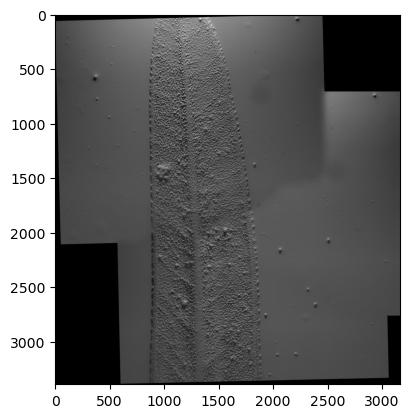

In [177]:
# test built-in stitching function

stitcher = cv.Stitcher.create(mode=cv.Stitcher_SCANS)
status, stitched = stitcher.stitch(ims)
 
if status != cv.Stitcher_OK:
    print("Can't stitch images, error code = %d" % status)
    sys.exit(-1)

plt.clf()
plt.imshow(stitched)
plt.show()

## gsmatlab demo code

Included below for reference

In [ ]:
"""
parentdr = '/Users/deryaakkaynak/Documents/Research_Local/Github/GelSight/gsmatlab/';
spath = fullfile(parentdr,'demo','groove','scan.yaml');
if ~exist(spath,'file')
    error('cannot find scan file for demo %s',spath);
end

hpath = fullfile(parentdr,'demo','groove','heightmap.tmd');
if ~exist(hpath,'file')
    error('cannot find TMD file %s',hpath);
end

sdata = readscan(spath);
lns = getshape(sdata.annotations, [], 'Line1');
if isempty(lns)
    error('cannot find line in scan file');
end
ln = lns{1};

[hm,dt] = readtmd(hpath);
mmpp = dt.mmpp;

% Load first image
im = im2double(imread(sdata.images(1).path));

% Get the profile from the heightmap
p = getprofile(hm, ln, mmpp);

% Level the profile using the spcified regions as the reference
[lp,A] = levelprofile(p, {[0.3 0.9], [3.1 3.6]});

% Dimensions in mm
xd = [1 size(hm,2)]*mmpp;
yd = [1 size(hm,1)]*mmpp;

figure(1)
clf
subplot(131)
imagesc(im,'XData',xd,'YData',yd);
colorbar
axis image 
title('image 1');
xlabel('X (mm)');
ylabel('Y (mm)');
hold on
plotshape('line',ln*mmpp); % Plot units are in mm, multiply by resolution

subplot(132)
imagesc(hm,'XData',xd,'YData',yd);
colorbar
axis image 
title('height (Z)');
xlabel('X (mm)');
ylabel('Y (mm)');
hold on
plotshape('line',ln*mmpp);

zmicrons = lp(2,:)*1000;
subplot(133)
plot(lp(1,:),zmicrons,'b','LineWidth',2);
xlabel('T (mm)');
ylabel(['Z (\mu' 'm)']);
title('Profile along line')
set(gca,'PlotBoxAspectRatio',[3 2 1]);
axis([lp(1,1) lp(1,end) min(zmicrons)-50 max(zmicrons)+50]);
grid on
"""